**Step 0 - install and import dependencies**

In [1]:
!pip install pythainlp
!pip install tensorflow_text
!pip install umap-learn

     |████████████████████████████████| 11.0 MB 5.1 MB/s 
     |████████████████████████████████| 743 kB 47.8 MB/s 
     |████████████████████████████████| 4.9 MB 4.6 MB/s 
     |████████████████████████████████| 86 kB 2.7 MB/s 
     |████████████████████████████████| 1.1 MB 36.0 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=a980c6614d9d530a96d1d7dedc605ac5041382bf201e36cf41748dc784139106
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=9951ef654dc8efcc014e0cd99b23b81ddd9efb6624a398c1f7f52f220167044e
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


In [243]:
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

--2021-12-31 12:49:15--  https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf [following]
--2021-12-31 12:49:15--  https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98308 (96K) [application/octet-stream]
Saving to: ‘thsarabunnew-webfont.ttf.1’

thsarabunnew-webfon 100%[===================>]  96.00K  --.-KB/s    in 0.01s   

2021-12-31 12:49:15 (6.72 MB/s) - 

In [307]:
import numpy as np
import pandas as pd
import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections

mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf') 
mpl.rc('font', family='TH Sarabun New')

In [308]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' 
#'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model

model = hub.load(module_url)

In [309]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [310]:
df = pd.read_csv("/content/drive/MyDrive/rawdata/Wongnai Reviews - Small.csv")
df.tail()

,Review ID,Review
295,296,ค่ำนี้คุณเพื่อนอยากส้มตำ หมูเฮาเลยพากันลงมากิน...
296,297,ร้านสะอาดดี ตกแต่งสวยงาม มีที่จอดรถ ราคาเมนูต่...
297,298,เช้าๆ รีบๆ วิ่งมาเข่าห้องเรียนแทบไม่ทันแต่ต้อง...
298,299,ร้านนี้เป็นร้านกาแฟเล็กๆ ข้างๆ ร้านๆ Happy Man...
299,300,ทรูคอฟฟี่สาขาซีคอนอยู่ในศูนย์บริการของทรู ชั้น...


In [311]:
# df_n = df.copy()

**Step 1 - document embedding and dimension reduction**

In [312]:
#embed sentences using Universal Sentence Encoder (USE)
#Botnoiw2v 

embed_comments_array = model(df['Review'].values).numpy()
embed_comments_array



array([[ 0.08993827,  0.01941084,  0.03787038, ..., -0.03488849,
         0.06299512,  0.04635989],
       [ 0.00634244,  0.00814594,  0.03071941, ..., -0.01478723,
        -0.03080936, -0.03316405],
       [ 0.0633687 , -0.02027139, -0.05077003, ..., -0.06530775,
        -0.00952999, -0.03439987],
       ...,
       [ 0.08775924,  0.03609736,  0.01263062, ..., -0.03102781,
        -0.03361677,  0.01928871],
       [ 0.05691195,  0.05381691, -0.0399575 , ..., -0.06598807,
        -0.05390478, -0.01037725],
       [ 0.0777048 ,  0.05080631,  0.02680681, ..., -0.0061413 ,
        -0.01313567,  0.02236264]], dtype=float32)

In [313]:
#reduce array dimensions using umap (you can chagne n_components)

reducer = umap.UMAP(random_state=42,n_components=50)
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)

**Step 2 - document clustering using KMeans**

Text(0, 0.5, 'WCSS')

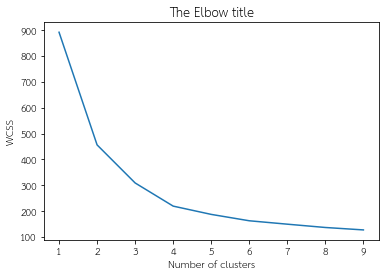

In [314]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10
for i in range(1, max_k):
  kmeans = KMeans(i)
  kmeans.fit(umap_embed_comments_array)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1, max_k)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

### K = 4

In [315]:
#run kmeans with no. of clusters you see fit the most

k = 4

kmeans = KMeans(n_clusters = k)
kmeans.fit(umap_embed_comments_array)

df['KMeans ID'] = kmeans.labels_

In [316]:
#merge all reviews of each cluster into one big sentence 

df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(df['Review'][df['KMeans ID'] == i].to_string())
  df_kmeans.loc[len(df_kmeans)] = row

In [317]:
df_kmeans

,KMeans ID,texts
0,0,13 เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่...
1,1,2 กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูห...
2,2,3 วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออก...
3,3,0 เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีว...


In [318]:
#create regex compiler for removal of a character you don't want

special_characters = "/[!@#$%^&*']/g"

specialchar_pattern = re.compile(special_characters)
specialchar_pattern

re.compile(r"/[!@#$%^&*']/g", re.UNICODE)

In [319]:
#create regex compiler for removal of any emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [320]:
#create regex compiler for removal of digit

number_pattern = re.compile("[0-9]")

In [321]:
#create regex compiler for removal of white space

space_pattern = re.compile("\s+")

In [322]:
mark_pattern = re.compile("[!@#$%^&*'][!@#$%^&*']?")

In [323]:
# onlyAword_pattern = re.compile("\w")

In [324]:
# notChar_pattern = re.compile("\W")

In [325]:
#create regex compiler for removal of .

dot_pattern = re.compile(r"\.+")

In [326]:
#create regex compiler for removal of \

backslash_pattern = re.compile(r"\\+")

In [327]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization

stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['u', 'b', 'n', 'nn', 'nn-', '\n', 'ร้าน', ]
new_removed_words = ['รีวิว','ผม','กก','สวัสดี',"['",' ','  ','\n','ร้าน','(',')','ๆ','-','--','.',',','{','}',':',';','/','>','<','"']


screening_words = stopwords + removed_words + new_removed_words

new_words = {"สตารบัก"}

# similar_word =

words = new_words.union(thai_words())

custom_dictionary_trie = Trie(words)

def tokenize_to_list(sentence):
  merged = []
  words = pythainlp.word_tokenize(str(sentence), engine='newmm', custom_dict=custom_dictionary_trie)
  for word in words:
    if word not in screening_words :
      merged.append(word)
      
  return merged

In [328]:
#clean and tokenize sentences. count the occurences of each word

df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

#Add Clean more

# df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: onlyAword_pattern.sub(r'', x))
# df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: notChar_pattern.sub(r'', x))
# df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: mark_pattern.sub(r'', x))

In [329]:
#results of tokenization

df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,เคยเป็นไหมกันไหมคะหลังอาหารมื้อใหญ่ต่อให้อิ่เช...,"[ไหม, ไหม, หลังอาหาร, มื้อ, ต่อให้, อิ่, เช้า,...","[(ชา, 18), (นม, 14), (ไข่มุก, 14), (ทาน, 6), (..."
1,1,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คส...,"[กวง, ทะเล, เผา, อาหารทะเล, เค้า, สด, เนื้อ, ป...","[(ร้านอาหาร, 11), (กิน, 7), (อร่อย, 6), (ซอย, ..."
2,2,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...,"[มีโอกาส, ตื่น, เช้า, โอกาส, มาหา, อะ, ไช, อบ,...","[(กิน, 10), (อร่อย, 9), (ทาน, 7), (บ้าน, 5), (..."
3,3,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดArt...,"[คน, ชอบ, ทาน, Macchiato, เป็นประจำ, นึง, เด, ...","[(ร้านกาแฟ, 22), (กาแฟ, 19), (ทาน, 11), (ชอบ, ..."


In [330]:
#show top keywords of each cluster

top_N_words = 20

for i in range(0, len(df_kmeans)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_N_words]}\n")

#tune a model by remove unwanted characters and words and add more words to a custom dictionary

Cluster ID : 0

Most common words include : [('ชา', 18), ('นม', 14), ('ไข่มุก', 14), ('ทาน', 6), ('เครื่องดื่ม', 4), ('ร้า', 3), ('ตั้งอยู่', 3), ('ลอง', 3), ('เดิน', 3), ('ไต้หวัน', 3), ('ไหม', 2), ('แวะ', 2), ('เติม', 2), ('นขา', 2), ('ชาเขียว', 2), ('นิว', 2), ('คุง', 2), ('เจอ', 2), ('ขาย', 2), ('Ochaya', 2)]

Cluster ID : 1

Most common words include : [('ร้านอาหาร', 11), ('กิน', 7), ('อร่อย', 6), ('ซอย', 6), ('อาหาร', 6), ('ทาน', 5), ('ราคา', 5), ('เพื่อน', 4), ('ส้มตำ', 4), ('ไทย', 4), ('แซ่บ', 4), ('รสชาติ', 4), ('ไร้', 3), ('าน', 3), ('ส', 3), ('ยำ', 3), ('รา', 3), ('เก่าแก่', 3), ('รอบ', 3), ('เป็ด', 3)]

Cluster ID : 2

Most common words include : [('กิน', 10), ('อร่อย', 9), ('ทาน', 7), ('บ้าน', 5), ('ร้านกาแฟ', 5), ('กาแฟ', 5), ('อาหาร', 4), ('ชอบ', 4), ('ร้านอาหาร', 4), ('มีโอกาส', 3), ('ถนน', 3), ('คิว', 3), ('กา', 3), ('ศ', 3), ('ครั้งแรก', 3), ('ซื้อ', 3), ('นะคะ', 3), ('เลือก', 3), ('บอ', 3), ('ลอง', 3)]

Cluster ID : 3

Most common words include : [('ร้านกาแฟ', 22), (

### K = 5

In [331]:
def VoC(df,k,top_N_words) :

  kmeans = KMeans(n_clusters = k)
  kmeans.fit(umap_embed_comments_array)

  df['KMeans ID'] = kmeans.labels_

  df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])

  for i in range(0, k):
    row = []
    row.append(i)
    row.append(df['Review'][df['KMeans ID'] == i].to_string())
    df_kmeans.loc[len(df_kmeans)] = row

  df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
  df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
  df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
  df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
  df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
  df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
  df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
  df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

  #Add Clean more

  # df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: onlyAword_pattern.sub(r'', x))
  # df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: notChar_pattern.sub(r'', x))
  # df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: mark_pattern.sub(r'', x))

  # top_N_words = 20

  for i in range(0, len(df_kmeans)):
    print(f"Cluster ID : {i}\n")
    print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_N_words]}\n")

In [332]:
VoC(df,5,20)

Cluster ID : 0

Most common words include : [('กิน', 10), ('อร่อย', 9), ('ทาน', 7), ('บ้าน', 5), ('ร้านกาแฟ', 5), ('กาแฟ', 5), ('อาหาร', 4), ('ชอบ', 4), ('ร้านอาหาร', 4), ('มีโอกาส', 3), ('ถนน', 3), ('คิว', 3), ('กา', 3), ('ศ', 3), ('ครั้งแรก', 3), ('ซื้อ', 3), ('นะคะ', 3), ('เลือก', 3), ('บอ', 3), ('ลอง', 3)]

Cluster ID : 1

Most common words include : [('ชา', 18), ('นม', 14), ('ไข่มุก', 14), ('ทาน', 6), ('เครื่องดื่ม', 4), ('ร้า', 3), ('ตั้งอยู่', 3), ('ลอง', 3), ('เดิน', 3), ('ไต้หวัน', 3), ('ไหม', 2), ('แวะ', 2), ('เติม', 2), ('นขา', 2), ('ชาเขียว', 2), ('นิว', 2), ('คุง', 2), ('เจอ', 2), ('ขาย', 2), ('Ochaya', 2)]

Cluster ID : 2

Most common words include : [('ร้านอาหาร', 11), ('กิน', 7), ('อร่อย', 6), ('ซอย', 6), ('อาหาร', 6), ('ทาน', 5), ('ราคา', 5), ('เพื่อน', 4), ('ส้มตำ', 4), ('ไทย', 4), ('แซ่บ', 4), ('รสชาติ', 4), ('ไร้', 3), ('าน', 3), ('ส', 3), ('ยำ', 3), ('รา', 3), ('เก่าแก่', 3), ('รอบ', 3), ('เป็ด', 3)]

Cluster ID : 3

Most common words include : [('ร้านกาแฟ', 13), (

In [333]:
VoC(df,6,20)

Cluster ID : 0

Most common words include : [('ร้านอาหาร', 11), ('อร่อย', 6), ('ซอย', 6), ('อาหาร', 6), ('ทาน', 5), ('กิน', 5), ('ส้มตำ', 4), ('ส', 4), ('ไทย', 4), ('ราคา', 4), ('แซ่บ', 4), ('เพื่อน', 3), ('ไร้', 3), ('าน', 3), ('ยำ', 3), ('รา', 3), ('เก่าแก่', 3), ('รอบ', 3), ('เป็ด', 3), ('ห', 3)]

Cluster ID : 1

Most common words include : [('ร้านกาแฟ', 7), ('เบเกอรี่', 4), ('พาย', 4), ('เค้ก', 3), ('คาเฟ่', 3), ('ชั้น', 3), ('ทาน', 2), ('กา', 2), ('จ', 2), ('ริ', 2), ('ชอบ', 2), ('เจอ', 2), ('กาแฟ', 2), ('บรรยากาศ', 2), ('คลาสสิค', 2), ('เด่น', 2), ('ตกแต่ง', 2), ('ร่ำ', 2), ('ตั้งอยู่', 2), ('รี่', 2)]

Cluster ID : 2

Most common words include : [('กิน', 8), ('ทาน', 4), ('บ้าน', 4), ('อร่อย', 4), ('อาหาร', 3), ('ไข่', 3), ('เมนู', 3), ('บอ', 3), ('ร้านอาหาร', 3), ('ดี', 3), ('สาขา', 3), ('ถนน', 3), ('ดีล', 3), ('มีโอกาส', 2), ('ชื่อดัง', 2), ('ข้าวห่อ', 2), ('เก', 2), ('เมือง', 2), ('พัทยา', 2), ('ทะเล', 2)]

Cluster ID : 3

Most common words include : [('ทาน', 7), ('ร้านกาแฟ', 

In [334]:
VoC(df,3,20)

Cluster ID : 0

Most common words include : [('ร้านกาแฟ', 25), ('กาแฟ', 22), ('ทาน', 13), ('กิน', 10), ('ชอบ', 9), ('คาเฟ่', 6), ('น', 6), ('แวะ', 6), ('ดี', 6), ('รี่', 5), ('อร่อย', 5), ('กา', 5), ('น่ารัก', 5), ('นั่ง', 5), ('เจอ', 5), ('หา', 5), ('คน', 4), ('นึง', 4), ('อ', 4), ('เบเกอรี่', 4)]

Cluster ID : 1

Most common words include : [('ร้านอาหาร', 14), ('กิน', 13), ('อร่อย', 11), ('ทาน', 10), ('อาหาร', 10), ('บ้าน', 6), ('ส้มตำ', 6), ('ซอย', 6), ('สาขา', 6), ('กาแฟ', 6), ('เพื่อน', 5), ('ไทย', 5), ('เมนู', 5), ('ถนน', 4), ('ราคา', 4), ('แซ่บ', 4), ('คน', 4), ('รอบ', 4), ('บอ', 4), ('เวลา', 4)]

Cluster ID : 2

Most common words include : [('ชา', 18), ('นม', 14), ('ไข่มุก', 14), ('ทาน', 6), ('เครื่องดื่ม', 4), ('ร้า', 3), ('น้ำ', 3), ('ตั้งอยู่', 3), ('ลอง', 3), ('เดิน', 3), ('ปั่น', 3), ('ไต้หวัน', 3), ('ไหม', 2), ('แวะ', 2), ('เติม', 2), ('นขา', 2), ('ชาเขียว', 2), ('นิว', 2), ('คุง', 2), ('เจอ', 2)]



**Step 3 - document clustering using Agglomorative Clustering with cosine similarity**

In [335]:
#clustering using agglomorative clustering

knn_graph = kneighbors_graph(embed_comments_array, 5, include_self=False)
model = AgglomerativeClustering(linkage="average", connectivity=knn_graph, n_clusters=10, affinity="cosine")
model.fit(embed_comments_array)
df['Agglomerative ID'] = model.labels_

In [336]:
#merge all reviews of each cluster into one big sentence 

df_Agglomerative = pd.DataFrame(columns=["Agglomerative ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(str(df['Review'][df['Agglomerative ID'] == i].tolist()))
  df_Agglomerative.loc[len(df_Agglomerative)] = row

In [337]:
#clean and tokenize sentences. count the occurences of each word

df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_Agglomerative['texts_tokenized'] = df_Agglomerative['texts'].apply(lambda x: tokenize_to_list(x))
df_Agglomerative['texts_count'] = df_Agglomerative['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

# Add
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: onlyAword_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: notChar_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: mark_pattern.sub(r'', x))

In [338]:
df_Agglomerative

,Agglomerative ID,texts,texts_tokenized,texts_count
0,0,,"[คน, ชอบ, ทาน, Macchiato, เป็นประจำ, นึง, เดิน...","[(อร่อย, 508), (ทาน, 416), (รสชาติ, 407), (ดี,..."
1,1,,"[ประโยชน์, น้ำ, แตงโม, ปั่น, แตงโม, พันธุ์, เล...","[(แตงโม, 22), (น้ำ, 8), (ปั่น, 6), (เนื้อ, 6),..."
2,2,,"[ดิ, ช้ัน, ทบ, น, อาหาร, เวลา, โมง, เย็น, แม่ศ...","[(ดิชั้น, 4), (แย่มาก, 3), (โต๊ะ, 2), (รอง, 2)..."
3,3,,"[เรื่อง, ขนม, สันทัด, ดังนั้น, review, เฉพาะเร...","[(นม, 3), (แน่น, 2), (tamp, 2), (เท, 2), (แก้,..."


In [339]:
#show top keywords of each cluster

top_N_words = 20

for i in range(0, len(df_Agglomerative)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_Agglomerative['texts_count'][i])[:top_N_words]}\n")

Cluster ID : 0

Most common words include : [('อร่อย', 508), ('ทาน', 416), ('รสชาติ', 407), ('ดี', 347), ('กิน', 339), ('กาแฟ', 311), ('เมนู', 309), ('สั่ง', 301), ('อาหาร', 285), ('ราคา', 273), ('ชา', 262), ('บาท', 242), ('ชอบ', 229), ('คน', 215), ("','", 215), ('หวาน', 206), ('นั่ง', 201), ('จาน', 196), ('ลอง', 178), ('นะคะ', 154)]

Cluster ID : 1

Most common words include : [('แตงโม', 22), ('น้ำ', 8), ('ปั่น', 6), ('เนื้อ', 6), ('เลือก', 4), ('ซื้อ', 4), ('ดื่ม', 4), ('พันธุ์', 3), ('รับประทาน', 3), ('แก้', 3), ('อาหาร', 3), ('ร่างกาย', 3), ('เมล็ด', 2), ('มีรส', 2), ('หวาน', 2), ('เย็น', 2), ('ยังมี', 2), ('วิตามิน', 2), ('สีแดง', 2), ('ผลไม้', 2)]

Cluster ID : 2

Most common words include : [('ดิชั้น', 4), ('แย่มาก', 3), ('โต๊ะ', 2), ('รอง', 2), ('แก้ว', 2), ('ดิ', 1), ('ช้ัน', 1), ('ทบ', 1), ('น', 1), ('อาหาร', 1), ('เวลา', 1), ('โมง', 1), ('เย็น', 1), ('แม่ศรี', 1), ('เรือน', 1), ('โฮมโปร', 1), ('แขก', 1), ('พนักงานบริการ', 1), ('เมนู', 1), ('ยืน', 1)]

Cluster ID : 3

Most co

**Step 4 - result discussion**

In [340]:
VoC(df,4,30)

Cluster ID : 0

Most common words include : [('ร้านอาหาร', 11), ('กิน', 7), ('อร่อย', 6), ('ซอย', 6), ('อาหาร', 6), ('ทาน', 5), ('ราคา', 5), ('เพื่อน', 4), ('ส้มตำ', 4), ('ไทย', 4), ('แซ่บ', 4), ('รสชาติ', 4), ('ไร้', 3), ('าน', 3), ('ส', 3), ('ยำ', 3), ('รา', 3), ('เก่าแก่', 3), ('รอบ', 3), ('เป็ด', 3), ('เมนู', 3), ('ห', 3), ('ดีล', 3), ('กาแฟ', 3), ('เนื้อ', 2), ('ถนน', 2), ('หัว', 2), ('หิน', 2), ('สไตล์', 2), ('บ้าน', 2)]

Cluster ID : 1

Most common words include : [('ร้านกาแฟ', 22), ('กาแฟ', 19), ('ทาน', 11), ('ชอบ', 8), ('คาเฟ่', 6), ('กิน', 6), ('แวะ', 6), ('น่ารัก', 5), ('น', 5), ('นั่ง', 5), ('เจอ', 5), ('คน', 4), ('นึง', 4), ('อ', 4), ('เบเกอรี่', 4), ('พาย', 4), ('วัง', 4), ('แนว', 4), ('กร้าน', 4), ('แถว', 4), ('เม', 4), ('ซอน', 4), ('บรรยากาศ', 4), ('ร', 4), ('ชั้น', 4), ('ดี', 4), ('ตั้งอยู่', 4), ('เด', 3), ('รสชาติ', 3), ('รี่', 3)]

Cluster ID : 2

Most common words include : [('ชา', 18), ('นม', 14), ('ไข่มุก', 14), ('ทาน', 6), ('เครื่องดื่ม', 4), ('ร้า', 3), ('ตั้งอ

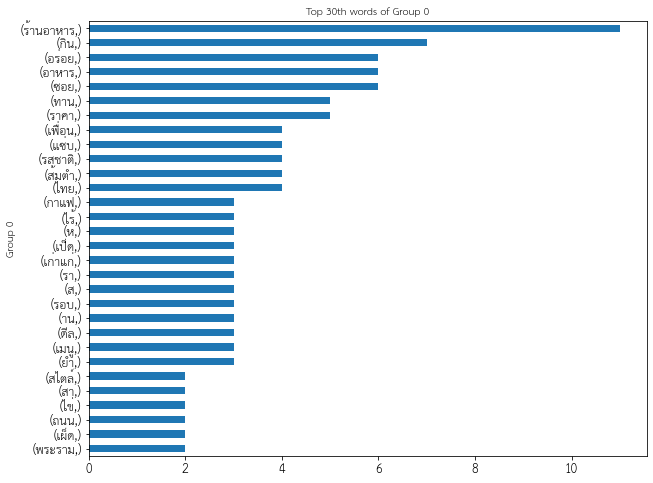

In [347]:
# Plot Bar Chart
df_plot0 = pd.DataFrame(df_kmeans['texts_tokenized'][1],columns=['Group 0'])
df_plot0.value_counts().head(30).sort_values(ascending=True).plot.barh(figsize=(10, 8), fontsize=12)
plt.title('Top 30th words of Group 0', fontsize=10)
plt.show()

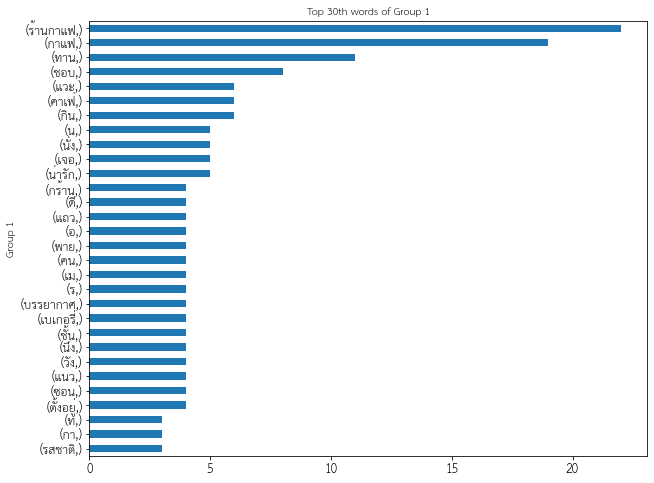

In [350]:
# Plot Bar Chart
df_plot1 = pd.DataFrame(df_kmeans['texts_tokenized'][3],columns=['Group 1'])
df_plot1.value_counts().head(30).sort_values(ascending=True).plot.barh(figsize=(10, 8), fontsize=12)
plt.title('Top 30th words of Group 1', fontsize=10)
plt.show()

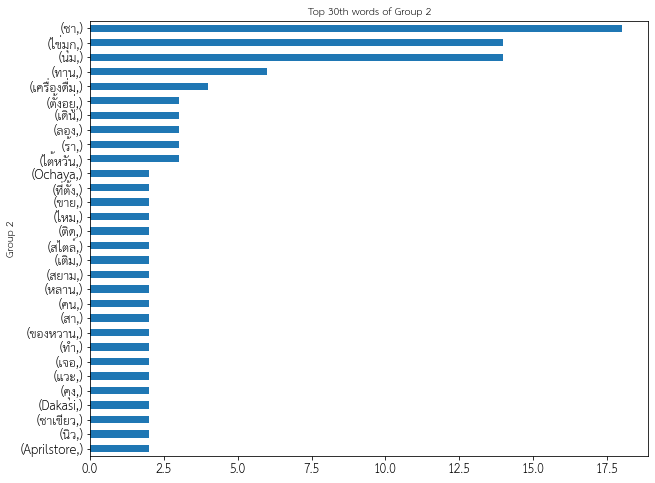

In [352]:
df_plot2 = pd.DataFrame(df_kmeans['texts_tokenized'][0],columns=['Group 2'])
df_plot2.value_counts().head(30).sort_values(ascending=True).plot.barh(figsize=(10, 8), fontsize=12)
plt.title('Top 30th words of Group 2', fontsize=10)
plt.show()

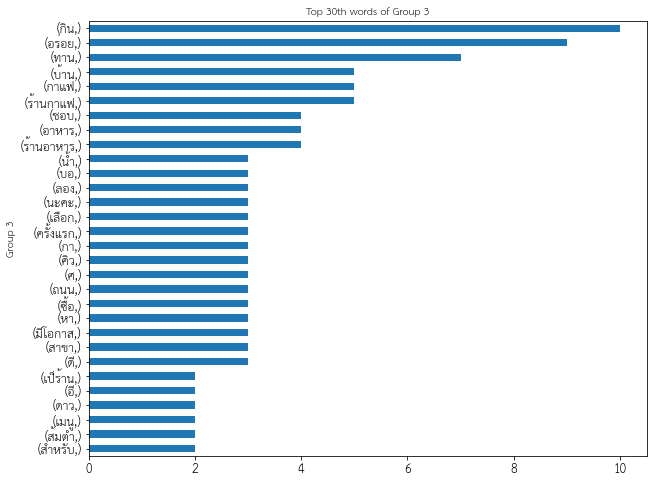

In [351]:
df_plot3 = pd.DataFrame(df_kmeans['texts_tokenized'][2],columns=['Group 3'])
df_plot3.value_counts().head(30).sort_values(ascending=True).plot.barh(figsize=(10, 8), fontsize=12)
plt.title('Top 30th words of Group 3', fontsize=10)
plt.show()

# สรุปขั้นตอนการทำครับ

1. พยายามคลีนข้อมูลให้ได้มากขึ้นครับ โดยการใส่ new_removed_words เพิ่มครับ
2. ลองใส่ pattern ของ Regex เข้าไปได้ไม่ค่อยช่วยเท่าไรครับ แถม pattern ยังดูพังๆ เหมือนกันครับ
3. ลองปรับค่า K เป็น 3,5,6 ดูครับ แต่สุดท้าย K = 4 ก็ยังเวิร์คที่สุดครับ (ถ้ามีข้อมูลเพิ่มขึ้น K อื่นๆ ก็อาจจะมีโอกาสเหมาะกว่าครับ)
4. ใช้ K-mean เวิร์คกว่าใช้ Agglomorative Clustering

สรุปผลลัพธ์แต่ละกลุ่ม คือ 

**กลุ่มหมาย 0** : เป็นการรีวิวร้านอาหารไทยรส เผ็ด จัดจ้าน เมนูออกทางอีสานแ เช่น ส้มตำ และพวกยำๆ ฯลฯ ครับ ถึงขั้นต้องชวนเพื่อนมากินด้วยความอร่อยมาก เป็นร้านเก่าแก่ น่ารับประทาน และน่าจะอยู่แถวถนนพระรามสักพระรามครับ

**กลุ่มหมาย 1** : เป็นการรีวิวร้านกาแฟและเบเกอรี่ ลักษณะร้านนั่ง ดูบรรยากาศ รสชาติอร่อย รีวิวเชิงบวก ชื่นชอบ น่ารัก

**กลุ่มหมาย 2** : เป็นการรีวิวการลองทานเกี่ยวร้านชานมไข่มุกไต้หวัน และ เครื่องดื่มครับ เช่น Ochaya , Dakasi เป็นต้นครับผม

**กลุ่มหมาย 3** : เป็นการรีวิวร้านอาหารและกาแฟ อาจน่าจะสไตล์ Caffe and restaurent ครับ และมีการรีวิวชมว่า อร่อย พูดถึงการกินและทานบ่อย เป็นการรีวิวที่เชิงบวกครับ 